# Introduction
State notebook purpose here

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [181]:
from noise_parameters import NOISE
from generate_timeseries import Timeseries, make_params
from noise_properties_plotting import PlotTimeseriesComparison, PlotNoiseColorComparison, PiecewiseNormalize
from scipy.optimize import curve_fit
from neutrality_analysis import KullbackLeibler_neutrality
from neutral_covariance_test import neutral_covariance_test
from scipy import stats

## Settings figures

In [11]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

In [81]:
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

## Experimental data

In [133]:
f = '../../Data/Faust/25_timeseries/25_timeseries.txt' # Stool A
x = np.loadtxt(f)

experimental = noise_color(x)
experimental['steady_state'] = np.median(x, axis=1)

experimental.sort_values(by='steady_state', inplace=True, ascending=False)
experimental.astype(float, copy=False)

,slope_linear,std_slope_linear,pvalue,slope_spline,steady_state
species_1,-0.707703,0.019432,9.946906e-07,-1.226732,1262.00000
species_2,-0.756404,0.019007,1.455237e-07,-0.785561,641.00000
species_3,-0.771402,0.020433,2.239110e-07,-0.791151,405.00000
species_5,-0.763854,0.016339,1.295882e-08,-1.550569,367.00000
species_4,-1.314492,0.015137,9.822188e-21,-1.416094,358.00000
...,...,...,...,...,...
species_99,-1.112867,0.019582,2.382118e-13,-1.245469,5.00000
species_93,-0.493099,0.020793,7.842600e-04,-1.012660,3.00000
species_60,-0.267688,0.022341,7.507418e-02,-2.207255,3.00000
species_78,-1.439354,0.014124,8.929784e-25,-1.710482,0.24259


# Different steady states, different implementations.

Create stochastic timeseries for non-interacting Lotka-Volterra systems with different steady states. (self-interaction = -1)

In [24]:
folder = 'results/without_interactions/'

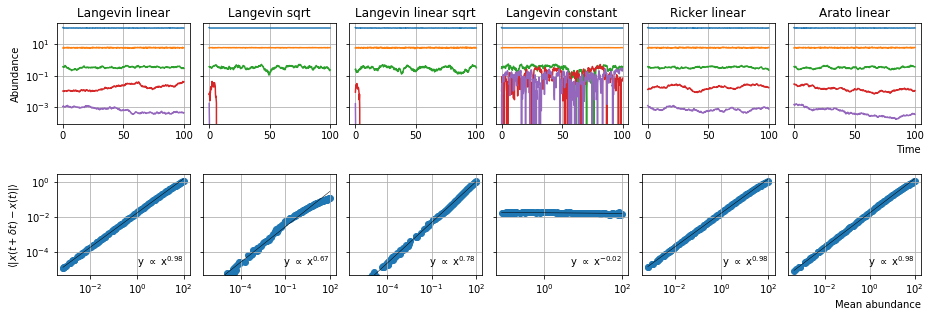

In [7]:
new = False

files_ts_impl = ['timeseries_Langevin_linear.csv', 'timeseries_Langevin_sqrt.csv', 
                 'timeseries_Langevin_linear_sqrt.csv', 'timeseries_Langevin_constant.csv',
                 'timeseries_Ricker_linear.csv', 'timeseries_Arato_linear.csv',
                ]
files_ts_impl = [folder + file for file in files_ts_impl]

titles = ['Langevin linear', 'Langevin sqrt', 'Langevin linear sqrt', 'Langevin constant',
          'Ricker linear',  'Arato linear']

implementations = [NOISE.LANGEVIN_LINEAR, NOISE.LANGEVIN_SQRT, NOISE.LANGEVIN_LINEAR_SQRT, NOISE.LANGEVIN_CONSTANT, 
                   NOISE.RICKER_LINEAR, NOISE.ARATO_LINEAR]

def create_new_files_different_implementations(params):
    for f, implementation in zip(files_ts_impl, implementations):
        if os.path.exists(f):
            os.remove(f)
        
        print(f)
        
        Timeseries(params, f = f, noise_implementation = implementation, 
                    dt = 0.01, tskip=4, T=100.0, seed=int(time.time()))

if new:
    N = 150
    steadystate = np.logspace(-3,2,N).reshape([N,1])

    params = make_params(steadystate)

    create_new_files_different_implementations(params)
    
fig = plt.figure(figsize=(15,5))

PlotTimeseriesComparison(files_ts_impl, titles = titles, 
                         composition = ['ts', 'dx'], fig=fig)

plt.show()

Power spectral density determines noise color

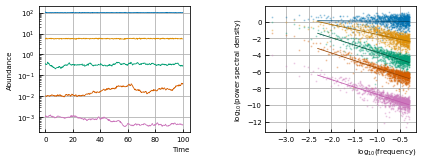

In [14]:
files_ts_impl = [folder + 'timeseries_Langevin_linear.csv', ]

fig = plt.figure(figsize=(0.9*ELIFE.FULLWIDTH,2.5)) #poster

PlotTimeseriesComparison(files_ts_impl, composition = ['ts', 'psd'], vertical=False, fig=fig)
plt.show()

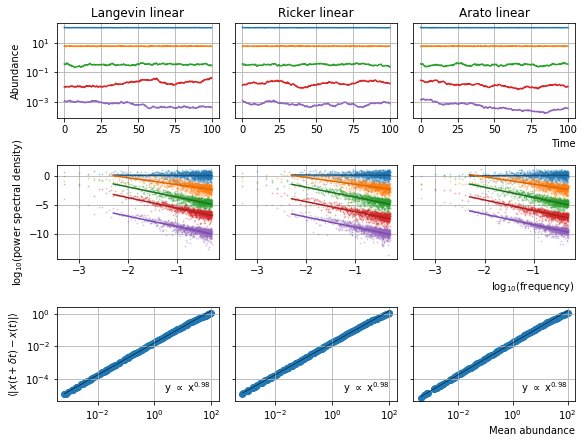

In [9]:
files_ts_impl = ['timeseries_Langevin_linear.csv', 
                  'timeseries_Ricker_linear.csv', 
                  'timeseries_Arato_linear.csv']
files_ts_impl = [folder + file for file in files_ts_impl]

titles = ['Langevin linear', 'Ricker linear',  'Arato linear']

PlotTimeseriesComparison(files_ts_impl, titles = titles, composition = ['ts', 'psd', 'dx'])
plt.show()

Generate multiple timeseries and take mean noise color.

/Users/wkits/Documents/VUB DO1/Code/logistic_models/noise_properties_plotting.py:504: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  aspect='auto', alpha=0.75)


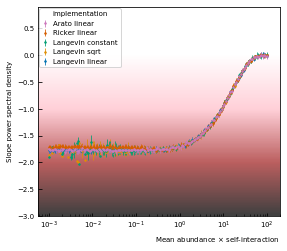

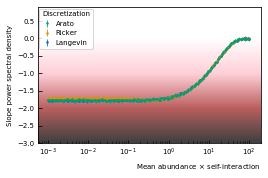

In [19]:
new = False

files_noise_impl = ['noise_abundance_Langevin_linear.csv',
                    'noise_abundance_Langevin_sqrt.csv',
                    'noise_abundance_Langevin_constant.csv',
                    'noise_abundance_Ricker_linear.csv',
                    'noise_abundance_Arato_linear.csv']
files_noise_impl = [folder + file for file in files_noise_impl]

labels = ['Langevin linear', 'Langevin sqrt',
          'Langevin constant', 'Ricker linear', 'Arato linear']


def mean_noise_color_abundance(steadystate):
    noise_colors = {label: pd.DataFrame() for label in labels}

    for file, label in zip(files_noise_impl, labels):
        noise_colors[label]['steady state'] = steadystate.flatten()

    for i in range(20):
        params = make_params(steadystate)

        create_new_files_different_implementations(params)

        for label, f in zip(labels, files_ts_impl):
            x = pd.read_csv(f)
            ns = noise_slope(x)
            noise_colors[label]['ts %d slope' %
                                (i+1)] = ns['slope_linear'].values
            noise_colors[label]['ts %d std' %
                                (i+1)] = ns['std_slope_linear'].values

    for label, file in zip(labels, files_noise_impl):
        noise_colors[label].to_csv(file)


if new:
    N = 150
    steadystate = np.logspace(-3, 2, N).reshape([N, 1])

    mean_noise_color_abundance(steadystate)

PlotNoiseColorComparison(files_noise_impl, labels, selfints=1, legend_title='implementation', ax=0, masi=True)

files_noise = ['noise_abundance_Langevin_linear.csv', 'noise_abundance_Ricker_linear.csv', 'noise_abundance_Arato_linear.csv']
files_noise = [folder + file for file in files_noise]

labels = ['Langevin', 'Ricker', 'Arato']

fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot(111)

PlotNoiseColorComparison(files_noise, labels, selfints=1,
                         legend_title='Discretization', ax=ax, masi=True)

plt.show()

Compare Langevin and Ricker implementation

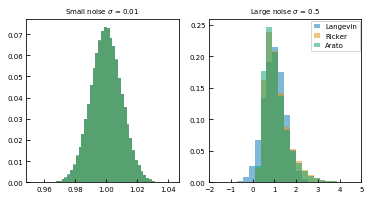

In [20]:
fig = plt.figure(figsize=(6,3))

mean = 1
sigma = 0.01
dt = sigma**2

gs = gridspec.GridSpec(1,2)

for sigma, gsi, title in zip([0.01, 0.5], gs, [r'Small noise $\sigma$ = 0.01', 
                                               r'Large noise $\sigma$ = 0.5']): 
    mean = 1
    dt = sigma**2

    ax = fig.add_subplot(gsi)
    ax.set_title(title)

    N = 100000
    
    dW = np.random.normal(0,1,N)

    Langevin = mean + mean*sigma*dW
    Ricker = mean*np.exp(sigma*dW)
    Arato = mean*np.exp((-sigma**2/2)*dt + sigma*dW)

    minX = min(min(Langevin), min(Ricker))
    maxX = max(max(Langevin), max(Ricker))
    dX = (maxX - minX)/48
    bins = np.linspace(minX - dX, maxX + dX, 50)

    for data, label in zip([Langevin, Ricker, Arato], ['Langevin', 'Ricker', 'Arato']):
        h, bins = np.histogram(data, bins=bins) 
        ax.bar(bins[:-1], h/N, width=np.diff(bins), align="edge", alpha=0.5, label=label)

ax.legend()
ax.set_xlim([-2, 5])

plt.show()

Different timelengths

In [21]:
new = False

N = 50

# no immigration
mu = np.zeros([N, 1])

files_ts_T = ['timeseries_Langevin_linear_timelength%d.csv' % i for i in range(1,6)]
files_ts_T = [folder + file for file in files_ts_T]

Tlengths = [1000.0, 500.0, 200.0, 100.0, 50.0]

labels = ['T = 1000', 'T = 500', 'T = 200', 'T = 100', 'T = 50']

def create_new_files_Langevin_different_timelengths(steadystate):
    for i, Tlength, f in zip(range(len(files_ts_T)), Tlengths, files_ts_T):
        if os.path.exists(f):
            os.remove(f)
        
        params = make_params(steadystate)
        
        if i == 0:
            ts = Timeseries(params, f=f, noise_implementation=NOISE.LANGEVIN_LINEAR,
                                 dt=0.01, tskip=4, T=Tlength).timeseries
        else:
            ts = pd.read_csv(files_ts_T[0], index_col=0)
            ts = ts.iloc[:int(len(ts)* Tlength / Tlengths[0])]
            ts.to_csv(f)

if new:
    steadystate = np.logspace(-3,2,N).reshape([N,1])
    create_new_files_Langevin_different_timelengths(steadystate)

In [22]:
new = False

files_noise_T = ['noisecolor_Langevin_linear_timelength%d.csv' % i for i in range(1,6)]
files_noise_T = [folder + file for file in files_noise_T]

labels = [1, 2, 3, 4, 5]

def mean_noise_color_abundance():
    noise_colors = {label : pd.DataFrame() for label, i in zip(labels,files_noise_T)}
        
    steadystate = np.logspace(-3,2,N).reshape([N,1])
        
    for file, label in zip(files_noise_T, labels):
        noise_colors[label]['steady state'] = steadystate.flatten()
    
    for i in range(20):
        create_new_files_Langevin_different_timelengths(steadystate)

        for label, f in zip(labels, files_ts_T):
            x = pd.read_csv(f)
            ns = noise_slope(x)
            
            noise_colors[label]['ts %d slope' % (i+1)] = ns['slope_linear'].values
            noise_colors[label]['ts %d std' % (i+1)] = ns['std_slope_linear'].values
    
    for label, file in zip(labels, files_noise_T):
        noise_colors[label].to_csv(file)

if new:
    mean_noise_color_abundance()

# Summary implementation

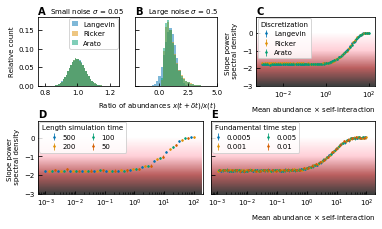

In [26]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,3))

gs1 = gridspec.GridSpec(1,1,left=0.65, right=0.95, top=0.92, bottom=0.6)
gs2 = gridspec.GridSpec(1,2,left=0.1, right=0.55, top=0.92, bottom=0.6)
gs3 = gridspec.GridSpec(1,2, left=0.1, right=0.95, top=0.44, bottom=0.1, wspace=0.05)

ax = fig.add_subplot(gs1[0])
ax.text(0, 1.15, 'C', transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='left')

files_noise = [folder + 'noise_abundance_' + imp + '.csv' for imp in 
               ['Langevin_linear', 'Ricker_linear', 'Arato_linear']]

labels = ['Langevin', 'Ricker', 'Arato']

all_data = [pd.read_csv(file) for file in files_noise]
turn_data = [df.iloc[np.arange(i, len(df), len(files_noise))] for i, df in enumerate(all_data)]

PlotNoiseColorComparison(turn_data, labels, selfints=1, legend_title='Discretization', ax=ax, masi=True)
ax.set_ylabel('Slope power \n spectral density')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Discretization')

for i, sigma, gsi, title in zip(range(2), [0.05, 0.5], gs2, 
                                [r'Small noise $\sigma$ = 0.05', 'Large noise $\sigma$ = 0.5']):
    if i == 1:
        ax = fig.add_subplot(gsi, sharey=ax)
    else:
        ax = fig.add_subplot(gsi)
        
    mean = 1
    dt = sigma**2

    N = 100000

    dW = np.random.normal(0,1,N)

    Langevin = mean + mean*sigma*dW
    Ricker = mean*np.exp(sigma*dW)
    Arato = mean*np.exp((-sigma**2/2)*dt + sigma*dW)

    minX = min(min(Langevin), min(Ricker))
    maxX = max(max(Langevin), max(Ricker))
    dX = (maxX - minX)/48
    bins = np.linspace(minX - dX, maxX + dX, 50)

    h, bins = np.histogram(Langevin, bins=bins) 
    ax.bar(bins[:-1], h/N, width=np.diff(bins), align="edge", alpha=0.5, label='Langevin')
    h, bins = np.histogram(Ricker, bins=bins) 
    ax.bar(bins[:-1], h/N, width=np.diff(bins), align="edge", alpha=0.5, label='Ricker')
    h, bins = np.histogram(Arato, bins=bins)
    ax.bar(bins[:-1], h/N, width=np.diff(bins), align="edge", alpha=0.5, label='Arato')
    
    ax.text(0, 1.15, 'A' if i == 0 else 'B', transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    ax.text(0.15, 1.15, title, transform=ax.transAxes, va='top', ha='left')

    if i > 0:
        ax.tick_params(axis='both', left=True, labelleft=False)
        ax.set_xlabel('Ratio of abundances ' 
                      + r'$x(t+\delta t) / x(t)$', ha='right', x=1)
    if i == 0:
        ax.legend()
        ax.set_ylabel('Relative count')
        
ax.set_xlim([-2, 5])

ax = fig.add_subplot(gs3[0])
ax.text(0, 1.15, 'D', transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='left')

files_noise_T = [folder + 'noisecolor_Langevin_linear_timelength%d.csv' % i for i in range(2,6)]
                
labels = [500, 200, 100, 50]

all_data = [pd.read_csv(file) for file in files_noise_T]
turn_data = [df.iloc[np.arange(i, len(df), len(files_noise_T))] for i, df in enumerate(all_data)]

pncc = PlotNoiseColorComparison(turn_data, labels, selfints=1, legend_title='Length simulation time', ax=ax, masi=True)
pncc.change_number_columns_legend(2)
ax.set_xlabel('')
ax.set_ylabel('Slope power \n spectral density')

ax = fig.add_subplot(gs3[1])
ax.text(0, 1.15, 'E', transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='left')


files_noise_dt = [folder + 'noise_abundance_Langevin_dt%d.csv' % i for i in range(1,5)]

labels = ['0.0005', '0.001', '0.005', '0.01'] 

all_data = [pd.read_csv(file) for file in files_noise_dt]
turn_data = [df.iloc[np.arange(i, len(df), len(files_noise_dt))] for i, df in enumerate(all_data)]

pncc = PlotNoiseColorComparison(turn_data, labels, selfints=1, legend_title='Fundamental time step', ax=ax, masi=True)
pncc.change_number_columns_legend(2)
ax.set_ylabel('')
ax.tick_params(axis='both', left=True, labelleft=False)

plt.show()

# Different self-interaction strengths

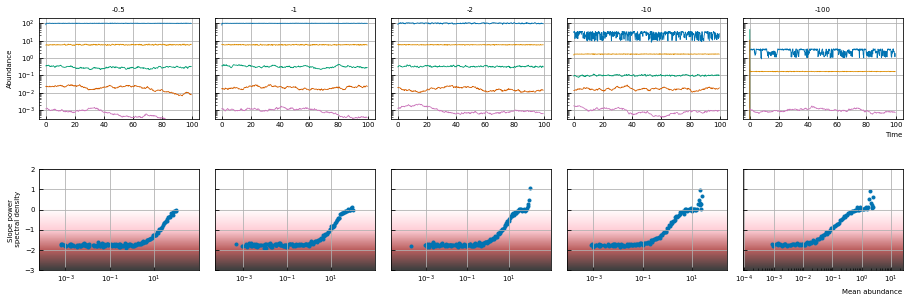

In [30]:
new = False

files_ts_selfints = [folder + 'timeseries_Langevin_selfint%d.csv' % i for i in range(1,6)]

titles = ['-0.5', '-1', '-2', '-10', '-100']

def create_new_files_different_selfinteractions():
    N = 150

    steadystate = np.logspace(-3,2,N).reshape([N,1])
    
    selfinteractions = [0.5, 1, 2, 10, 100]

    for f, selfinteraction in zip(files_ts_selfints, selfinteractions):
        if os.path.exists(f):
            os.remove(f)
                
        params = make_params(steadystate, selfint=selfinteraction)
        
        Timeseries(params, f = f, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                            dt = 0.01, tskip=4, T=100.0, seed=int(time.time()))

if new:
    create_new_files_different_selfinteractions()
    
PlotTimeseriesComparison(files_ts_selfints, titles = titles, composition=['ts', 'nc'])

plt.show()

In [28]:
new = False

def mean_noise_color_abundance():
    files_ts_selfints = [folder + 'timeseries_Langevin_selfint%d.csv' % i for i in range(1,6)]
    files_noise_selfint = [folder + 'noise_abundance_Langevin_selfint%d.csv' % d for d in range(1,6)]
    labels = ['-0.5', '-1', '-2', '-10', '-100']
    
    N = 150
    
    noise_colors = {label : pd.DataFrame(index=['species_%d' % i for i in range(1,N+1)]) for label in labels}
    
    for file, label in zip(files_noise_selfint, labels):
        steadystate = np.logspace(-3,2,N).reshape([N,1])
        noise_colors[label]['steady state'] = steadystate.flatten()
    
    for i in range(20):
        create_new_files_different_selfinteractions()

        for label, f in zip(labels, files_ts_selfints):
            x = pd.read_csv(f)
            ns = noise_slope(x)
            noise_colors[label]['ts %d slope' % (i+1)] = ns['slope_linear'].values
            noise_colors[label]['ts %d std' % (i+1)] = ns['std_slope_linear'].values
    
    for label, file in zip(labels, files_noise_selfint):
        noise_colors[label].to_csv(file)

if new:
    mean_noise_color_abundance()

/Users/wkits/Documents/VUB DO1/Code/logistic_models/noise_properties_plotting.py:505: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  else:


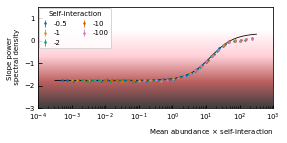

[ 2.09919542  2.86702746  1.14133479 -1.77108643]
The parameters of the sigmoid function are: amplitude = 2.099E+00, x0 = 2.867E+00, k = 1.141E+00, offset = -1.771E+00


In [38]:
files_noise_selfint = [folder + 'noise_abundance_Langevin_selfint%d.csv' % d for d in range(1,6)]
labels = ['-0.5', '-1', '-2', '-10', '-100']
selfints = [0.5, 1, 2, 10, 100]

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)

all_data = [pd.read_csv(file, index_col=0).dropna() for file in files_noise_selfint]
turn_data = [df.iloc[np.arange(0, len(df), len(files_noise_selfint))] for i, df in enumerate(all_data)]

nc_plot = PlotNoiseColorComparison(turn_data, labels=labels, selfints=selfints, 
                         legend_title='Self-interaction', ax = ax)
nc_plot.set_limits([1e-4, 1e3, -3, 1.5])
nc_plot.change_number_columns_legend(2)
ax.set_ylabel('Slope power \n spectral density')

f, selfint = files_noise_selfint[0], selfints[0]

data = pd.read_csv(f)
x = np.log10( data['steady state'] * selfint ) # steady state * self-interaction
y = np.mean( data[[col for col in data if col.endswith('slope')]].T )

def sigmoid(x, amplitude, x0, k, offset):
    return amplitude * 1.0/(1.0 + np.exp(-x0*(x-k))) + offset

data.dropna(inplace=True)

pars, pcov = curve_fit(sigmoid, x, y, [1,1,1, -1.5])

ax.plot(np.logspace(-3.5,2.5,100), sigmoid(np.log10(np.logspace(-3.5,2.5,100)), 
        pars[0], pars[1], pars[2], pars[3]), c = 'k')
    
plt.show()

print("The parameters of the sigmoid function are: amplitude = %.3E, x0 = %.3E, k = %.3E, offset = %.3E" % tuple(pars))

These curves are translations of each other if mean abundance on the x-axis

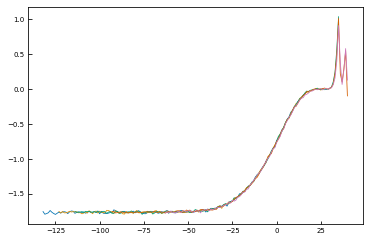

In [39]:
files_noise_selfint = [folder + 'noise_abundance_Langevin_selfint%d.csv' % d for d in range(1,6)]
labels = ['-0.5', '-1', '-2', '-10', '-100']

for f, label in zip(files_noise_selfint, labels):
    x = pd.read_csv(f)

    x = x[[col for col in x if col.endswith('slope')]]

    sigma_shape = np.mean(x.T).values
    
    x_shift = np.nanargmin(abs(sigma_shape+0.75))
        
    plt.plot(range(-x_shift, len(sigma_shape)-x_shift), sigma_shape)
    
plt.show()

# Different growth rates

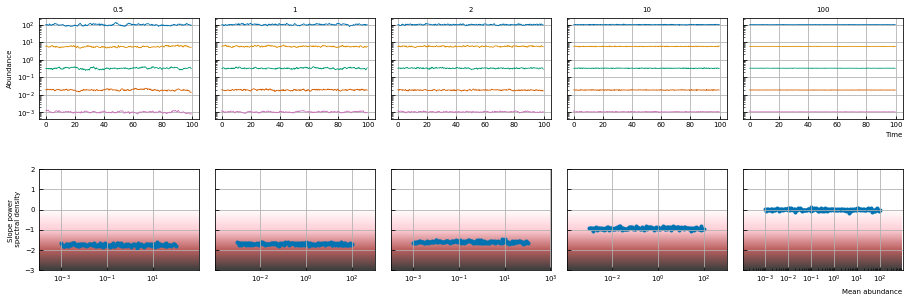

In [40]:
new = False

files_ts_growth_rates = [folder + 'timeseries_Langevin_growth_rate%d.csv' % i for i in range(1,6)]

titles = ['0.5', '1', '2', '10', '100']

def create_new_files_different_growth_rates():
    N = 150

    params = {}

    steadystate = np.logspace(-3,2,N).reshape([N,1])

    # no immigration
    params['immigration_rate'] = np.zeros([N, 1])

    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

    params['noise'] = 1e-1

    params['noise_linear'] = 1e-1
    params['noise_sqrt'] = 1e-2

    growth_rates = [0.5, 1, 2, 10, 100]

    for f, growth_rate in zip(files_ts_growth_rates, growth_rates):
        if os.path.exists(f):
            os.remove(f)
         
        # different growth rates determined by the steady state
        g = np.full([N,1], growth_rate)
        params['growth_rate'] = g
        
        # no interaction + calculate selfinteraction
        omega = np.zeros([N, N]); np.fill_diagonal(omega, - g / steadystate)
        params['interaction_matrix'] = omega
        
        Timeseries(params, f = f, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                    dt = 0.01, tskip=4, T=100.0, seed=int(time.time()))

if new:
    create_new_files_different_growth_rates()
    
PlotTimeseriesComparison(files_ts_growth_rates, titles = titles, composition=['ts', 'nc'])

plt.show()

# Different noise strengths Langevin linear.

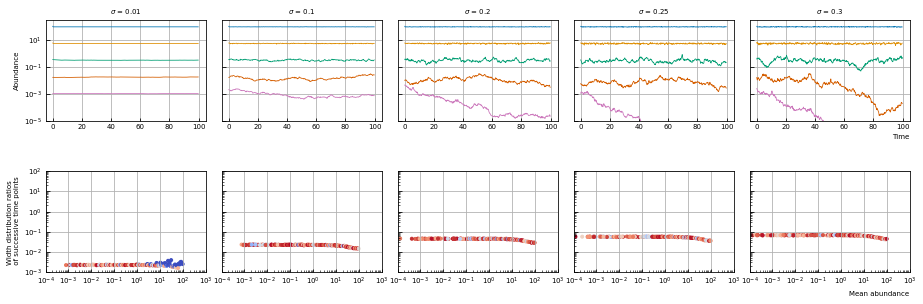

In [43]:
new = False

N = 150
steadystate = np.logspace(-3,2,N).reshape([N,1])

params = make_params(steadystate)

files_ts_sigma = [folder + 'timeseries_Langevin_linear_sigma%d.csv' % i for i in range(1,6)]

titles = ['$\sigma$ = 0.01', '$\sigma$ = 0.1', '$\sigma$ = 0.2', '$\sigma$ = 0.25', '$\sigma$ = 0.3']

noise_strength = [0.01, 0.1, 0.2, 0.25, 0.3]

labels = ['$\sigma$ = 0.01', '$\sigma$ = 0.1', '$\sigma$ = 0.2', '$\sigma$ = 0.25', '$\sigma$ = 0.3']

def create_new_files_Langevin_different_noise_strengths():
    for f, noise in zip(files_ts_sigma, noise_strength):
        if os.path.exists(f):
            os.remove(f)
        
        params['noise_linear'] = noise
        
        Timeseries(params, f = f,
                            noise_implementation = NOISE.LANGEVIN_LINEAR,
                             dt = 0.01, tskip=4, T=100.0)

if new:
    create_new_files_Langevin_different_noise_strengths()

ts_plot = PlotTimeseriesComparison(files_ts_sigma, titles, composition=['ts', 'disdx'])
ts_plot.axes['disdx'][0].set_ylim([1e-3, 1e2])
for ax in ts_plot.axes['disdx']:
    ax.set_xlim([1e-4, 1e3])
plt.show()

/Users/wkits/Documents/VUB DO1/Code/logistic_models/noise_properties_plotting.py:505: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  aspect='auto', alpha=0.75)


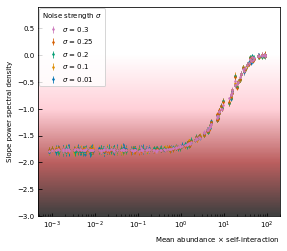

In [45]:
new = False

files_noise_sigma = [folder + 'noise_abundance_Langevin_linear_sigma%d.csv' % i for i in range(1,6)] 
noise = ['0.01', '0.1', '0.2', '0.25', '0.3'] 

def mean_noise_color_abundance():
    noise_colors = [pd.DataFrame() for i in range(len(files_noise_sigma))]
    
    for i in range(len(files_noise_sigma)):
        noise_colors[i]['steady state'] = initcond.flatten()
    
    for i in range(20):
        create_new_files_Langevin_different_noise_strengths()

        for j, f in enumerate(files_ts_sigma):
            x = pd.read_csv(f)
            ns = noise_slope(x)
            noise_colors[j]['ts %d slope' % (i+1)] = ns['slope_linear'][1:].values
            noise_colors[j]['ts %d std' % (i+1)] = ns['std_slope_linear'][1:].values
    
    for i in range(len(files_noise_sigma)):
        noise_colors[i].to_csv(files_noise_sigma[i][0])

if new:
    mean_noise_color_abundance()
    
PlotNoiseColorComparison(files_noise_sigma[::-1], labels, selfints=1, 
                         legend_title='Noise strength $\sigma$', ax=0, masi=True)
plt.show()

# Different noise strengths Langevin constant

In [46]:
new = False

N = 150

params = {}

steadystate = np.logspace(-3,2,N).reshape([N,1])

# no interaction
omega = np.zeros([N, N]); np.fill_diagonal(omega, -1)

params['interaction_matrix'] = omega

# no immigration
params['immigration_rate'] = np.zeros([N, 1])

# different growth rates determined by the steady state
params['growth_rate'] = - (omega).dot(steadystate)


params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

params['noise'] = 1e-1

params['noise_linear'] = 1e-1
params['noise_sqrt'] = 1e-2

files_ts_constant_sigma = [folder + 'timeseries_Langevin_constant_sigma%d.csv' % i for i in range(1,6)] 

noise_strength = [0.01, 0.1, 0.2, 0.5, 1]
labels = ['$\sigma$ = 0.01', '$\sigma$ = 0.1', '$\sigma$ = 0.2', '$\sigma$ = 0.5', '$\sigma$ = 1']

def create_new_files_Langevin_constant_different_noisestrengths():
    for f, noise in zip(files_ts_constant_sigma, noise_strength):
        if os.path.exists(f):
            os.remove(f)
        
        params['noise'] = noise
        
        Timeseries(params, f = f,
                            noise_implementation = NOISE.LANGEVIN_CONSTANT,
                             dt = 0.01, tskip=4, T=100.0)

if new:
    create_new_files_Langevin_constant_different_noisestrengths()

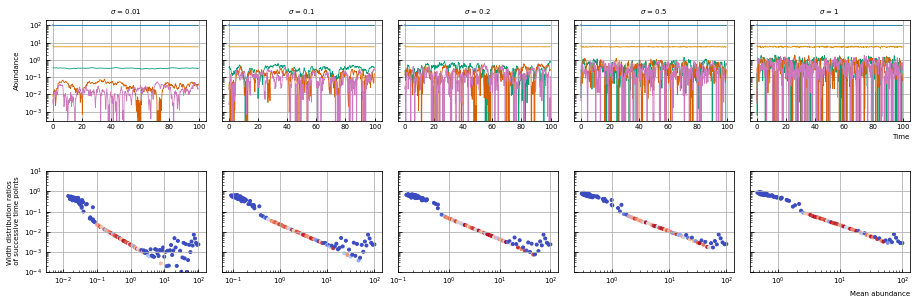

In [48]:
ts_plot = PlotTimeseriesComparison(files_ts_constant_sigma, labels, composition=['ts', 'disdx'])
ts_plot.axes['disdx'][0].set_ylim([1e-4, 1e1])

plt.show()

/Users/wkits/Documents/VUB DO1/Code/logistic_models/noise_properties_plotting.py:504: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  self.background = self.ax.imshow(x, cmap=noise_cmap_ww, vmin=noise_lim[0], vmax=noise_lim[1], extent=(0, 200, -3, 0.9),


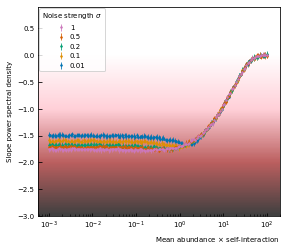

In [56]:
new = False

files_noise_constant_sigma = [folder + 'noise_abundance_Langevin_constant_sigma%d.csv' % i for i in range(1,6)]

labels = ['0.01', '0.1', '0.2', '0.5', '1']

def mean_noise_color_abundance():
    noise_colors = [pd.DataFrame() for i in range(len(files_noise_constant_sigma))]
    
    for i in range(len(noise_colors)):
        noise_colors[i]['steady state'] = initcond.flatten()
    
    for i in range(20):
        create_new_files_Langevin_constant_different_noisestrengths()

        for j, f in enumerate(files_ts_constant_sigma):
            x = pd.read_csv(f[0])
            ns = noise_slope(x)
            noise_colors[j]['ts %d slope' % (i+1)] = ns['slope_linear'][1:].values
            noise_colors[j]['ts %d std' % (i+1)] = ns['std_slope_linear'][1:].values
    
    for i in range(len(files_noise_constant_sigma)):
        noise_colors[i].to_csv(files_noise_constant_sigma[i])

if new:
    mean_noise_color_abundance()
    
PlotNoiseColorComparison(files_noise_constant_sigma[::-1], labels, selfints=1, 
                  legend_title='Noise strength $\sigma$', ax=0, masi=True)
plt.show()

# Different initial conditions

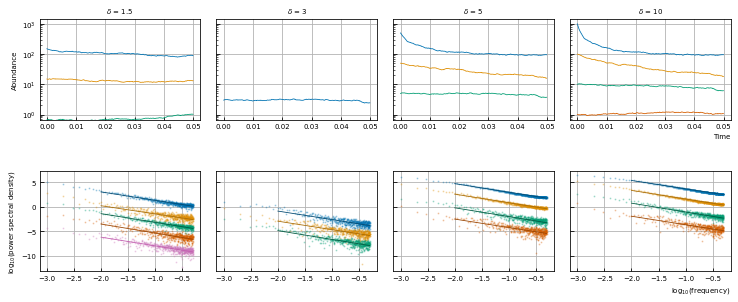

In [208]:
new = False

N = 5

params = {}

steadystate = np.logspace(-2,2,N).reshape([N,1])

# no interaction
omega = np.zeros([N, N]); np.fill_diagonal(omega, -1)

params['interaction_matrix'] = omega

# no immigration
params['immigration_rate'] = np.zeros([N, 1])

# different growth rates determined by the steady state
params['growth_rate'] = - (omega).dot(steadystate)


params['noise'] = 1e0

files_ts_ic = [folder + 'timeseries_Langevin_linear_initcond%d.csv' % i for i in range(1,5)]

deviations = [1.5, 3, 5, 10]

labels = ['$\delta$ = 1.5', '$\delta$ = 3', '$\delta$ = 5', '$\delta$ = 10']

def create_new_files_Langevin_different_initial_conditions():
    for f, deviation in zip(files_ts_ic, deviations):
        if os.path.exists(f):
            os.remove(f)
        
        signs = np.random.choice([-1,1], steadystate.shape)
        params['initial_condition'] = np.copy(steadystate) * deviation**signs
        
        Timeseries(params, f = f,
                            dt = 1e-5, tskip=4, T=5e-2)

if new:
    create_new_files_Langevin_different_initial_conditions()
    
PlotTimeseriesComparison(files_ts_ic, labels, composition=['ts', 'psd'])
plt.show()

Very fast convergence to steady state. No large influence on noise color.

# Different fundamental time steps

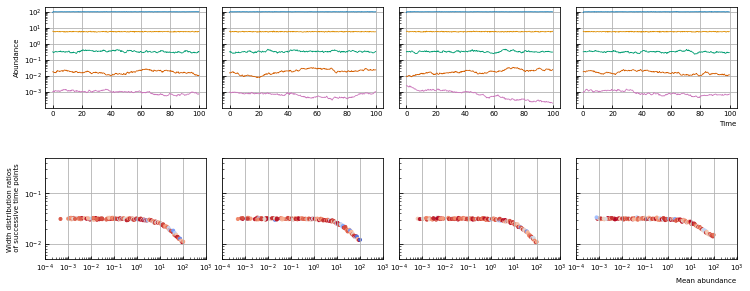

In [52]:
new = False

# save only for dt = 0.1
files_ts_dt = [folder + 'timeseries_Langevin_linear_dt%d.csv' %
               i for i in range(1, 5)]

skips = [199, 99, 19, 9]

labels = ['$\delta t$ = 0.0005', '$\delta t$ = 0.001',
          '$\delta t$ = 0.005', '$\delta t$ = 0.01']

params = {}

steadystate = np.logspace(-3, 2, N).reshape([N, 1])

# no interaction
omega = np.zeros([N, N])
np.fill_diagonal(omega, -1)

params['interaction_matrix'] = omega

# no immigration
params['immigration_rate'] = np.zeros([N, 1])

# different growth rates determined by the steady state
params['growth_rate'] = - (omega).dot(steadystate)


params['initial_condition'] = np.copy(
    steadystate) * np.random.normal(1, 0.1, steadystate.shape)

params['noise'] = 1e-1

params['noise_linear'] = 1e-1
params['noise_sqrt'] = 1e-2


def create_new_files_Langevin_different_timesteps():
    for f, skip in zip(files_ts_dt, skips):
        if os.path.exists(f):
            os.remove(f)

        Timeseries(params, f=f, noise_implementation=NOISE.LANGEVIN_LINEAR,
                   dt=0.1/(skip + 1), tskip=skip, T=100.0)


if new:
    create_new_files_Langevin_different_timesteps()

ts_plot = PlotTimeseriesComparison(files_ts_dt, titles, composition=['ts', 'disdx'])
ts_plot.axes['disdx'][0].set_ylim([5e-3, 5e-1])
for ax in ts_plot.axes['disdx']:
    ax.set_xlim([1e-4, 1e3])
    
plt.show()

/Users/wkits/Documents/VUB DO1/Code/logistic_models/noise_properties_plotting.py:504: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  self.background = self.ax.imshow(x, cmap=noise_cmap_ww, vmin=noise_lim[0], vmax=noise_lim[1], extent=(0, 200, -3, 0.9),


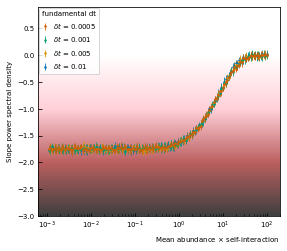

In [54]:
new = False

files_noise_dt = [folder + 'noise_abundance_Langevin_dt%d.csv' % i for i in range(1,5)]

dt = ['0.0005', '0.001', '0.005', '0.01']

def mean_noise_color_abundance():
    noise_colors = [pd.DataFrame() for i in range(len(files_noise_dt))]
    
    steadystate = np.logspace(-3,2,N).reshape([N,1])
    
    for noise_colors_i in noise_colors:
        noise_colors_i['steady state'] = steadystate.flatten()
    
    for i in range(1, 21):
        create_new_files_Langevin_different_timesteps()

        for j, f in enumerate(files_ts_dt):
            x = pd.read_csv(f, index_col=1)
            ns = noise_slope(x)
            noise_colors[j]['ts %d slope' % i] = ns['slope_linear'].values
            noise_colors[j]['ts %d std' % i] = ns['std_slope_linear'].values
    
    for i, noise_colors_i in enumerate(noise_colors):
        noise_colors_i.to_csv(files_noise_dt[i][0])

if new:
    mean_noise_color_abundance()

PlotNoiseColorComparison(files_noise_dt[::-1], labels[::-1], legend_title='fundamental dt')
plt.show()

# Different sampling rates

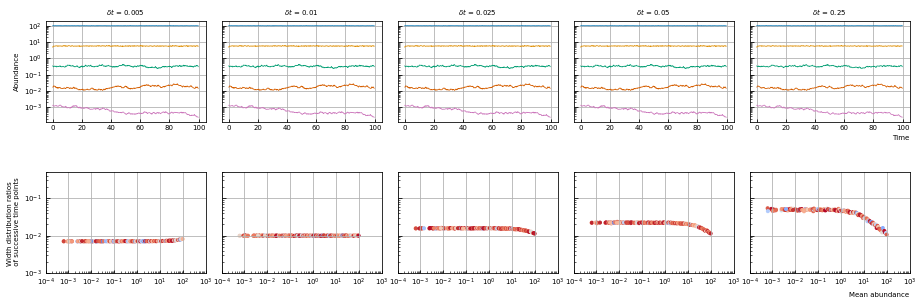

In [55]:
new = False 

files_ts_samp = [folder + 'timeseries_Langevin_linear_samp%d.csv' % i for i in range(1,6)]

skips = [0, 1, 4, 9, 49]

labels = ['$\delta t$ = 0.005', '$\delta t$ = 0.01', '$\delta t$ = 0.025', 
          '$\delta t$ = 0.05', '$\delta t$ = 0.25']

params = {}

steadystate = np.logspace(-3,2,N).reshape([N,1])

# no interaction
omega = np.zeros([N, N]); np.fill_diagonal(omega, -1)

params['interaction_matrix'] = omega

# no immigration
params['immigration_rate'] = np.zeros([N, 1])

# different growth rates determined by the steady state
params['growth_rate'] = - (omega).dot(steadystate)


params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

params['noise'] = 1e-1

params['noise_linear'] = 1e-1
params['noise_sqrt'] = 1e-2

def create_new_files_Langevin_different_samplings():
    N = 150
    
    # first simulate smallest timestep
    
    f0 = files_ts_samp[0]
    
    if os.path.exists(f0):
            os.remove(f0)
            
    Timeseries(params, f = f0,
                        noise_implementation = NOISE.LANGEVIN_LINEAR, 
                        dt = 0.005, T=100.0)
    
    # take different samplings
    for f, skip in zip(files_ts_samp[1:], skips[1:]):
        if os.path.exists(f):
            os.remove(f)

        d = pd.read_csv(f0, index_col=0)
        d = d.iloc[::(skip+1)]

        d.to_csv(f)

if new:
    create_new_files_Langevin_different_samplings()

ts_plot = PlotTimeseriesComparison(files_ts_samp, labels, composition=['ts', 'disdx'])
ts_plot.axes['disdx'][0].set_ylim([1e-3, 5e-1])
for ax in ts_plot.axes['disdx']:
    ax.set_xlim([1e-4, 1e3])
    
plt.show()

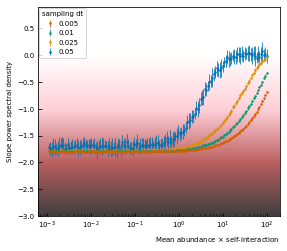

In [58]:
new = False

files_noise_samp = [folder + 'noise_abundance_Langevin_samp%d.csv' % i for i in range(1,5)]

labels = ['0.005', '0.01', '0.025', '0.05'] #, '0.25']

def mean_noise_color_abundance():
    noise_colors = [pd.DataFrame() for i in range(len(files_noise_samp))]
    
    N = 150
    steadystate = np.logspace(-3,2,N).reshape([N,1])
    
    for noise_colors_i in noise_colors:
        noise_colors_i['steady state'] = steadystate.flatten()
    
    for i in range(1, 21):
        create_new_files_Langevin_different_samplings()

        for j, f in enumerate(files_ts_samp):
            x = pd.read_csv(f, index_col=1)
            ns = noise_slope(x)
            noise_colors[j]['ts %d slope' % i] = ns['slope_linear'].values
            noise_colors[j]['ts %d std' % i] = ns['std_slope_linear'].values
    
    for i, noise_colors_i in enumerate(noise_colors):
        noise_colors_i.to_csv(files_noise_samp[i][0])

if new:
    mean_noise_color_abundance()

PlotNoiseColorComparison(files_noise_samp[::-1], labels[::-1], legend_title='sampling dt')

# Summary figure no interactions

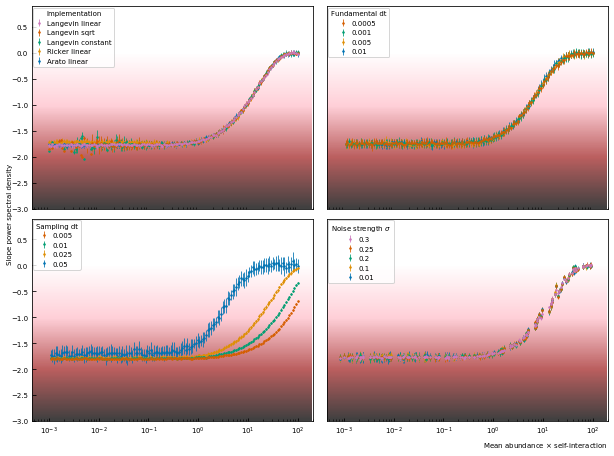

In [59]:
fig = plt.figure(figsize=(10, 8))

gs = gridspec.GridSpec(2, 2, top=0.9, bottom=0.18, left=0.1,
                       right=0.9, wspace=0.05, hspace=0.05)
gs_tot = gridspec.GridSpec(1, 1, top=0.9, bottom=0.18, left=0.08, right=0.9)

ax_tot = fig.add_subplot(gs_tot[0], frameon=False)
ax_tot.tick_params(axis='both', left=False, labelleft=False,
                   bottom=False, labelbottom=False)

# implementation

ax = fig.add_subplot(gs[0])

files_noise = [folder + 'noise_abundance_' + imp + '.csv' for imp in ['Langevin_linear',
                                                                      'Langevin_sqrt', 
                                                                      'Langevin_constant', 
                                                                      'Ricker_linear', 
                                                                      'Arato_linear']][::-1]

labels = ['Langevin linear', 'Langevin sqrt',
          'Langevin constant', 'Ricker linear', 'Arato linear'][::-1]

PlotNoiseColorComparison(files_noise, labels, legend_title='Implementation', ax=ax)
ax.tick_params(axis="both", bottom=False, top=False,
               labelbottom=False, labeltop=False)
ax.set_xlabel('')
ax.set_ylabel('')

# fundamental dt

ax = fig.add_subplot(gs[1], sharex=ax, sharey=ax)

files_noise_dt = [folder + 'noise_abundance_Langevin_dt%d.csv' % i for i in range(1,5)]

labels = ['0.0005', '0.001', '0.005', '0.01']

PlotNoiseColorComparison(
    files_noise_dt[::-1], labels[::-1], legend_title='Fundamental dt', ax=ax)
ax.tick_params(axis="both", bottom=False, top=False,
               labelbottom=False, labeltop=False, left=False, labelleft=False)
ax.set_xlabel('')
ax.set_ylabel('')

# sampling dt

ax = fig.add_subplot(gs[2], sharex=ax, sharey=ax)

files_noise_samp = [folder + 'noise_abundance_Langevin_samp%d.csv' % i for i in range(1,5)]

labels = ['0.005', '0.01', '0.025', '0.05'] #, '0.25']

PlotNoiseColorComparison(
    files_noise_samp[::-1], labels[::-1], legend_title='Sampling dt', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')

# noise strength

ax = fig.add_subplot(gs[3], sharex=ax, sharey=ax)

files_noise_sigma = [folder + 'noise_abundance_Langevin_linear_sigma%d.csv' % i for i in range(1,6)]
                    
labels = ['0.01', '0.1', '0.2', '0.25', '0.3']

PlotNoiseColorComparison(
    files_noise_sigma[::-1], labels, legend_title='Noise strength $\sigma$', ax=ax)
ax.tick_params(axis="both", bottom=True, labelbottom=True,
               left=False, labelleft=False)
ax.set_ylabel('')

ax_tot.set_ylabel('Slope power spectral density')

plt.show()

# Large noise make species go extinct

$d x_i = \lambda_i dt + g_i x_i dt + \sum_j \omega_{ij} x_i x_j dt + x_i \sigma dW$

If $\sigma dW > g_i dt$, than the species number will decrease (is this true?)

In steady state $x_i^* = g_i$, so when $\sigma \sqrt{dt} > g_i dt$ the species number will decrease. (?)

For $dt = 0.01$, $\sigma > 0.1 x_i^*$.

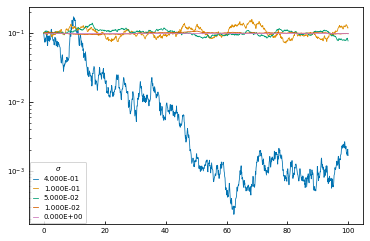

In [209]:
new = False

f = folder + 'largenoise.csv'
noise = np.array([0, 1e-2,5e-2,1e-1,4e-1]); N = len(noise)

if new:
    params = {}

    params['noise_linear'] = noise.reshape([N,1])
    
    initcond = 0.1*np.ones([N,1])
    params['initial_condition'] = initcond
    
    # no interaction
    omega = np.zeros([N, N]); np.fill_diagonal(omega, -1)
    params['interaction_matrix'] = omega
    
    # no immigration
    params['immigration_rate'] = np.zeros([N, 1])

    # different growth rates determined by the steady state
    params['growth_rate'] = - (omega).dot(initcond)

    if os.path.exists(f):
        os.remove(f)

    Timeseries(params, T=100, f = f,
               noise_implementation = NOISE.LANGEVIN_LINEAR)

x = pd.read_csv(f)

for j in range(N,0,-1):
    plt.plot(x['time'][::10], x['species_%d'%j][::10], label='%.3E' % noise[j-1])
plt.yscale('log')
plt.legend(title = r'$\sigma$')
plt.show()

# Neutrality

In [63]:
def plot_neutrality_measures(neutrality, labels, figsize=(12,4.5), y=0.75):
    fig = plt.figure(figsize=figsize)
    gs1 = gridspec.GridSpec(2,1,hspace=0, left = 0.1, bottom=y)
    gs2 = gridspec.GridSpec(1,2,wspace=0.2, top=0.2)

    ax_KL = fig.add_subplot(gs1[0])
    ax_clb_KL = fig.add_subplot(gs2[0])
    ax_NCT = fig.add_subplot(gs1[1])
    ax_clb_NCT = fig.add_subplot(gs2[1])
    ax_KL.set_facecolor('lightgrey')
    ax_NCT.set_facecolor('lightgrey')

    x = np.log10(neutrality['KL'].values.astype(np.float64))
    x = x.reshape([1, len(x)])
    x[np.isinf(x)] = 3.0
    mat_KL = ax_KL.matshow(x, origin='lower', 
                        cmap='Blues', aspect='auto', vmin=-1, vmax=3)
    ax_KL.set_yticks([0])
    ax_KL.set_yticklabels([r'log$_{10}$($D_{KL}$)'], fontsize=10)

    ax_KL.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)

    fig.colorbar(mat_KL, cax=ax_clb_KL, orientation='horizontal')
    ax_clb_KL.set_title(r'log$_{10}$($D_{KL}$)')

    x = np.log10(neutrality['NCT'].values.astype(np.float64))
    x = x.reshape([1, len(x)])

    vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
    norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
    mat_NCT = ax_NCT.matshow(x, origin='lower', norm=norm, 
                         cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
    fig.colorbar(mat_NCT, cax=ax_clb_NCT, orientation='horizontal')

    ax_NCT.set_xticks(range(len(x[0])))
    ax_NCT.set_xticklabels(labels)

    ax_NCT.set_yticks([0])
    ax_NCT.set_yticklabels([r'log$_{10}$($p_{NCT}$)'], fontsize=10)

    # Set ticks on both sides of axes on
    ax_NCT.tick_params(axis="both", bottom=True, top=False, labelbottom=True, labeltop=False, left=True, labelleft=True)
    ax_clb_NCT.set_title(r'log$_{10}$($p_{NCT}$)')

    # Rotate and align bottom ticklabels
    plt.setp([tick.label1 for tick in ax_NCT.xaxis.get_major_ticks()], rotation=90,
             ha="right", va="center", rotation_mode="anchor", fontsize=10)
    plt.setp([tick.label1 for tick in ax_NCT.yaxis.get_major_ticks()], fontsize=10)

    ax_clb2 = ax_clb_KL.twiny()
    ax_clb_KL.xaxis.set_ticks_position('bottom')
    ax_clb2.xaxis.set_ticks_position('top')
    ax_clb2.xaxis.set_ticks([0.05,0.95])
    ax_clb2.set_xlim([0,1])
    ax_clb2.xaxis.set_ticklabels(['neutral','niche'])

    ax_clb2 = ax_clb_NCT.twiny()
    ax_clb_NCT.xaxis.set_ticks_position('bottom')
    ax_clb2.xaxis.set_ticks_position('top')
    ax_clb2.xaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                            1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
    ax_clb2.set_xlim([0,1])
    ax_clb2.xaxis.set_ticklabels(['niche','neutral'])

In [75]:
if False:
    files = ['timeseries_Langevin_linear.csv', 
             'timeseries_Langevin_sqrt.csv', 
             'timeseries_Langevin_linear_sqrt.csv',
             'timeseries_Ricker_linear.csv', 
             'timeseries_Arato_linear.csv',
             'timeseries_Langevin_linear_sigma1.csv',
             'timeseries_Langevin_linear_sigma2.csv',
             'timeseries_Langevin_linear_sigma3.csv',
             'timeseries_Langevin_linear_sigma4.csv',
             'timeseries_Langevin_linear_sigma5.csv',
             'timeseries_Langevin_linear_dt1.csv', 
             'timeseries_Langevin_linear_dt3.csv', 
             'timeseries_Langevin_linear_dt2.csv',  
             'timeseries_Langevin_linear_dt4.csv',
             'timeseries_Langevin_linear_samp1.csv',
             'timeseries_Langevin_linear_samp2.csv',
             'timeseries_Langevin_linear_samp3.csv', 
             'timeseries_Langevin_linear_samp4.csv',
             'timeseries_Langevin_linear_samp4.csv'
            ]

    labels = ['Langevin linear', 'Langevin sqrt', 'Langevin linear sqrt',
                 'Ricker linear',  'Arato linear', 
             r'$\sigma$ = 0.01', r'$\sigma$ = 0.1', r'$\sigma$ = 0.2', r'$\sigma$ = 0.25', r'$\sigma$ = 0.3',
            'fundamental $\delta t$ = 0.0005', 'fundamental $\delta t$ = 0.001', 
              'fundamental $\delta t$ = 0.005', 'fundamental $\delta t$ = 0.01',
              'sampling $\delta$t = 0.005', 'sampling $\delta$t = 0.01', 
              'sampling $\delta$t = 0.025', 'sampling $\delta$t = 0.05',
              'sampling $\delta$t = 0.25'
             ]

    df_ts = {label : pd.read_csv(folder + file) for label, file in zip(labels, files)}

    neutrality = pd.DataFrame(columns=['KL', 'NCT'], index=labels)

    for label in labels:
        if np.isnan(neutrality['NCT'].loc[label]):
            neutrality['KL'].loc[label] = KullbackLeibler_neutrality(df_ts[label])

            norm_ts = df_ts[label].values[:, 1:]
            norm_ts /= norm_ts.sum(axis=1, keepdims=True)

            neutrality['NCT'].loc[label] = neutral_covariance_test(norm_ts, ntests=500, method = 'Kolmogorov', seed=56)
    
    neutrality.to_csv(folder + 'neutrality.csv')
else:
    neutrality = pd.read_csv(folder + 'neutrality.csv', index_col=0)

neutrality

,KL,NCT
Langevin linear,inf,2.149809e-01
Langevin sqrt,NaN,1.333268e-111
Langevin linear sqrt,inf,2.221053e-03
Ricker linear,inf,6.141094e-06
Arato linear,inf,1.341640e-01
$\sigma$ = 0.01,1.048046e+07,5.206795e-315
$\sigma$ = 0.1,inf,1.287714e-10
$\sigma$ = 0.2,inf,4.998548e-01
$\sigma$ = 0.25,inf,2.022498e-01
$\sigma$ = 0.3,inf,3.966121e-02


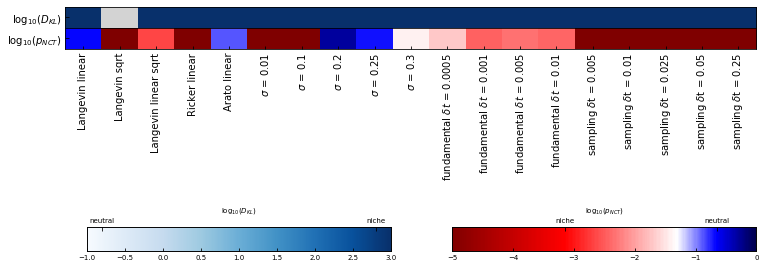

In [78]:
plot_neutrality_measures(neutrality, labels)

plt.show()

check neutrality of multiple copies of the 'Langevin linear' type

In [79]:
new = False

N = 50

params = {}

#steadystate = np.logspace(-3,2,N).reshape([N,1]) # np.ones([N,1])*10
steadystate = np.ones([N,1])

# no interaction
omega = np.zeros([N, N]); np.fill_diagonal(omega, -1)
#for i in range(len(omega)):
#    omega[i] /= experimental_abundance[i]

params['interaction_matrix'] = omega

# no immigration
params['immigration_rate'] = np.zeros([N, 1])

# different growth rates determined by the steady state
params['growth_rate'] = - (omega).dot(steadystate)

params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

params['noise'] = 5e-1

params['noise_linear'] = 1e-1
params['noise_sqrt'] = 1e-2

def check_neutrality_Langevin_linear(Ncopies):
    neutrality = pd.DataFrame(columns=['KL', 'NCT'], index=range(Ncopies))

    for label in range(Ncopies):
        print(label)
        ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                            dt = 0.01, tskip=4, T=100.0, seed=int(time.time())).timeseries
        
        #for i in range(N):
        #    ts['species_%d' % (i+1)] *= experimental_abundance[i] / ts['species_%d' % (i+1)].mean()
    
        if np.isnan(neutrality['NCT'].loc[label]):
            neutrality['KL'].loc[label] = KullbackLeibler(ts)

            norm_ts = ts.values[:, 1:]
            norm_ts /= norm_ts.sum(axis=1, keepdims=True)

            neutrality['NCT'].loc[label] = neutral_covariance_test(norm_ts, ntests=500, method = 'Kolmogorov', seed=56)

    return neutrality
        
if new:
    Ncopies = 5
    
    n = check_neutrality_Langevin_linear(Ncopies)
    
    plot_neutrality_measures(n, range(Ncopies), (8,2.5), 0.6)
    plt.show()
    

# Rescaled model

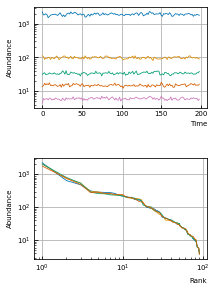

In [80]:
N = 90

params = {}

steadystate = np.ones([N,1])

# interaction
omega = np.zeros([N,N]); np.fill_diagonal(omega, -1)

params['interaction_matrix'] = omega

# no immigration
params['immigration_rate'] = np.zeros([N, 1])

# different growth rates determined by the steady state
params['growth_rate'] = - (omega).dot(steadystate)

params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

params['noise'] = 1

params['noise_linear'] = 1e-1
params['noise_sqrt'] = 1e-2

ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                    dt = 0.01, tskip=149, T=200.0, seed=int(time.time())).timeseries

for i in range(N):
    ts['species_%d' % (i+1)] *= experimental['steady_state'].iloc[i] / ts['species_%d' % (i+1)].mean()

ts_plot = PlotTimeseriesComparison([ts], composition=['ts', 'ra'])

# print("Kullback Leibler divergence", KullbackLeibler(ts))

norm_ts = ts.values[:, 1:]
norm_ts /= norm_ts.sum(axis=1, keepdims=True)

# print("NCT", neutral_covariance_test(norm_ts, ntests=500, method = 'Kolmogorov', seed=56))



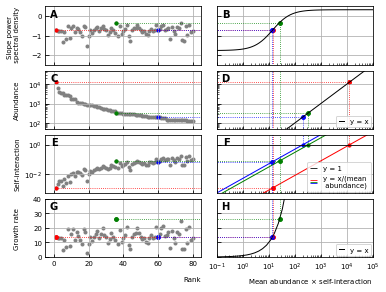

In [192]:
N = 80

steadystate = (experimental['steady_state'].values[:N]).reshape([N, 1]) * 10

def find_ss_selfint(x):
    amplitude = 2.10E+00 
    x0 = 2.87E+00
    k = 1.14E+00
    offset = -1.77E+00

    return 10**( -1/x0 * np.log(amplitude/(x-offset) - 1) + k)

def sigmoid(x):
    amplitude = 2.10E+00 
    x0 = 2.87E+00
    k = 1.14E+00
    offset = -1.77E+00
    
    return amplitude * 1.0/(1.0 + np.exp(-x0*(np.log10(x)-k))) + offset
    
noisecolor = np.copy(experimental['slope_linear'].values[:N])

selfints = -find_ss_selfint(noisecolor) / steadystate.flatten()

omega = np.zeros([N, N]); np.fill_diagonal(omega, selfints)
growth_rate = - (omega).dot(steadystate)

idces = [0, 35, 59]
colors = ['r', 'g', 'b']

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,4))
gs = gridspec.GridSpec(4,2, hspace=0.1, wspace=0.1, top=0.95, bottom=0.08, right=0.95)

ps = 10 # point size

ax_nc = fig.add_subplot(gs[0,0])
ax_ma = fig.add_subplot(gs[1,0], sharex=ax_nc)
ax_si = fig.add_subplot(gs[2,0], sharex=ax_nc)
ax_g = fig.add_subplot(gs[3,0], sharex=ax_nc)
ax_r1 = fig.add_subplot(gs[0,1], sharey=ax_nc)
ax_r2 = fig.add_subplot(gs[1,1], sharey=ax_ma, sharex=ax_r1)
ax_r3 = fig.add_subplot(gs[2,1], sharey=ax_si, sharex=ax_r1)
ax_r4 = fig.add_subplot(gs[3,1], sharey=ax_g, sharex=ax_r1)

for ax, label in zip([ax_nc, ax_r1, ax_ma, ax_r2, ax_si, ax_r3, ax_g, ax_r4],
                     ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']):
    ax.grid()
    ax.text(0.08, 0.95, label, transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='right')

for ax in [ax_ma, ax_nc, ax_si, ax_r1, ax_r2, ax_r3]:
    ax.tick_params(axis='both', bottom=True, labelbottom=False)

for ax in [ax_r1, ax_r2, ax_r3, ax_r4]:
    ax.tick_params(axis='both', left=True, labelleft=False)
    
ax_g.set_xlabel('Rank', ha='right', x=1)
ax_r4.set_xlabel(r'Mean abundance $\times$ self-interaction', ha='right', x=1)

ax_nc.scatter(np.arange(1, N+1), noisecolor, c='grey')
#ax.set_yscale('log')
ax_nc.tick_params(axis='both', bottom=True, labelbottom=False)
ax_nc.set_ylabel('Slope power \n spectral density')
for i, c in zip(idces, colors):
    ax_nc.scatter([i+1], noisecolor[i], s=ps, c=c)
    ax_nc.plot([i+1, N+10], [noisecolor[i],noisecolor[i]], c=c, ls=':')
ax_nc.set_xlim([-5,N+5])

ax_ma.scatter(np.arange(1, N+1), steadystate, c='grey')
ax_ma.set_yscale('log')
for i, c in zip(idces, colors):
    ax_ma.scatter([i+1], steadystate[i], s=ps, c=c)
    ax_ma.plot([i+1, N+10], [steadystate[i],steadystate[i]], c=c, ls=':')
ax_ma.tick_params(axis='both', bottom=True, labelbottom=False)
ax_ma.set_ylabel('Abundance')

ax_si.scatter(np.arange(1, N+1), -selfints, c='grey')
for i, c in zip(idces, colors):
    ax_si.scatter([i+1], -selfints[i], s=ps, c=c)
    ax_si.plot([i+1, N+10], [-selfints[i],-selfints[i]], c=c, ls=':')
ax_si.set_ylabel('Self-interaction')
ax_si.set_yscale('log')
ax_si.set_ylim([1e-4, 1e0])

ax_g.scatter(np.arange(1, N+1), growth_rate, c='grey')
for i, c in zip(idces, colors):
    ax_g.scatter([i+1], growth_rate[i], s=15, c=c)
    ax_g.plot([i+1, N+10], [growth_rate[i],growth_rate[i]], c=c, ls=':')
ax_g.set_ylabel('Growth rate')

x = np.logspace(-3,6,100)
ax_r1.plot(x, sigmoid(x), 'k', linewidth=1)
for i, c in zip(idces, colors):
    si = find_ss_selfint(noisecolor[i])
    xx = si
    yy = sigmoid(si)
    ax_r1.scatter([xx], [yy], s=15, c=c)
    ax_r1.plot([1e-4, xx], [yy,yy], c=c, ls=':')
    ax_r1.plot([xx,xx], [-3,yy], c=c, ls=':')
ax_r1.set_xscale('log')
ax_r1.set_ylim([-2.5,0.5])

for i, c in zip(idces, colors):
    sssi = find_ss_selfint(noisecolor[i])
    xx = sssi
    yy = steadystate[i]
    #ax_r2.scatter([xx], [yy], s=15, c=c)
    ax_r2.scatter([yy], [yy], s=15, c=c)
    #ax_r2.plot(x, yy/xx*x , c=c, linewidth=1)
    ax_r2.plot([xx, xx], [1e1,5e4], c=c, ls=':')
    ax_r2.plot([0, yy], [yy,yy], c=c, ls=':')
    ax_r2.plot([yy, yy], [1e1,yy], c=c, ls=':')
ax_r2.plot(x, x, c='k', linewidth=1, label='y = x')
ax_r2.set_xscale('log')
ax_r2.set_ylim([5e1, 5e4])
ax_r2.legend(loc=4)

x = np.logspace(-10,5,100)
for i, c in zip(idces, colors):
    xx = find_ss_selfint(noisecolor[i])
    yy = xx/steadystate[i] # selfinteraction[i]
    ax_r3.scatter([xx], [yy], s=15, c=c)
    ax_r3.scatter([steadystate[i]], [1], s=10, c=c)
    ax_r3.plot(x, yy/xx*x , c=c, linewidth=1)
    ax_r3.plot([0, xx], [yy,yy], c=c, ls=':')
    ax_r3.plot([xx, xx], [1e-4,10], c=c, ls=':')
    ax_r3.plot([steadystate[i], steadystate[i]], [1e0,1e1], c=c, ls=':')
ax_r3.axhline(y=1, c='k', label='y = 1')
ax_r3.set_ylim([5e-4, 5e0])
line = [[(0, 0)]]
lc = mcol.LineCollection(line, linestyles = ['solid'], colors = ['black'])
lc2 = mcol.LineCollection(3 * line, colors=colors)
ax_r3.legend([lc, lc2], ['y = 1', 'y = x/(mean \n abundance)'], handler_map={type(lc): HandlerDashedLines()},
          handlelength=1, handleheight=1)
handle, label = ax.get_legend_handles_labels()


#ax_r3.legend(loc=4)

ax_r4.plot(x, x, c='k', linewidth=1, label='y = x')
for i, c in zip(idces, colors):
    xx = find_ss_selfint(noisecolor[i])
    yy = xx
    ax_r4.scatter([xx], [yy], s=15, c=c)
    ax_r4.plot([0, xx], [yy,yy], c=c, ls=':')
    ax_r4.plot([xx,xx], [yy,50], c=c, ls=':')
    
ax_r4.set_xlim([1e-1, 1e5])
ax_r4.set_ylim([0, 40])
ax_r4.legend(loc=4)

fig.align_labels()
plt.show()

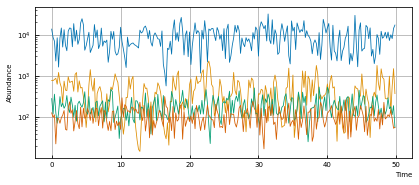

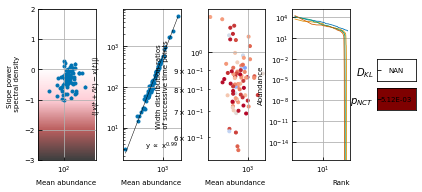

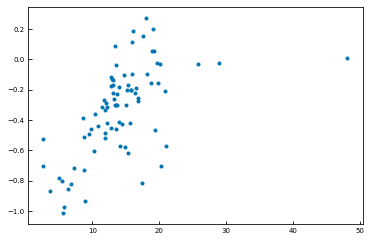

In [193]:
N = 80

new = True
save = False

if new:
    def find_ss_selfint(x):
        amplitude = 2.10E+00 
        x0 = 2.87E+00
        k = 1.14E+00
        offset = -1.77E+00

        return 10**( -1/x0 * np.log(amplitude/(x-offset) - 1) + k)

    params = {}

    steadystate = (experimental['steady_state'].values[:N]).reshape([N, 1]) * 10

    selfints = -find_ss_selfint(experimental_noise_color['slope_linear'].values[:N]) / steadystate.flatten()

    #print('self interaction', selfints)

    # interaction
    omega = np.zeros([N,N]); np.fill_diagonal(omega, selfints) #np.random.uniform(-1, 0, N)) # np.random.normal(0,0.02,[N, N]);

    params['interaction_matrix'] = omega

    # no immigration
    params['immigration_rate'] = np.zeros([N, 1])

    # different growth rates determined by the steady state
    params['growth_rate'] = - (omega).dot(steadystate)

    #print('growth_rate', params['growth_rate'].flatten())

    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

    params['noise'] = 2.5

    params['noise_linear'] = 2.5
    params['noise_sqrt'] = 0 #0.005*steadystate #*np.sqrt(steadystate)

    ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR_SQRT, 
                        dt = 0.01, tskip=19, T=50.0, seed=int(time.time())).timeseries
    
    if save:
        ts.to_csv(folder + 'rescaled_timeseries.csv', index=False)
        np.savetxt(folder + 'rescaled_interactionmatrix.txt', omega)
        np.savetxt(folder + 'rescaled_growth_rate.txt', params['growth_rate'])
else:
    ts = pd.read_csv(folder + 'rescaled_timeseries.csv')
    
    
fig = plt.figure(figsize=(0.9*ELIFE.FULLWIDTH,3))

PlotTimeseriesComparison([ts], composition=['ts'], vertical=False, fig=fig)

fig = plt.figure(figsize=(0.9*ELIFE.FULLWIDTH,3)) #poster

PlotTimeseriesComparison([ts], composition=['nc', 'dx', 'disdx', 'ra', 'nn'], vertical=False, fig=fig) #, ffig = 'figures/interaction_rescaled_model.png')

ns = noise_color(ts)['slope_linear']
plt.figure()
plt.scatter(-selfints*steadystate.flatten(), ns.values)
plt.show()

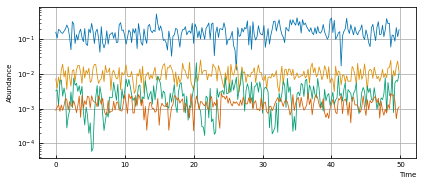

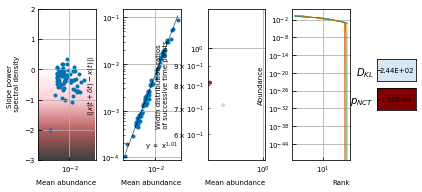

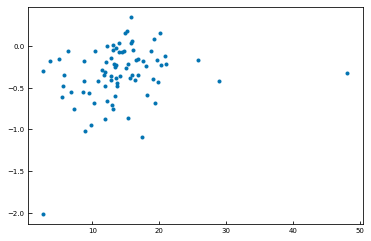

In [190]:
N = 80

new = False
save = False

if new:
    def find_ss_selfint(x):
        amplitude = 2.10E+00 
        x0 = 2.87E+00
        k = 1.14E+00
        offset = -1.77E+00

        return 10**( -1/x0 * np.log(amplitude/(x-offset) - 1) + k)

    params = {}

    steadystate = (experimental_abundance[:N]).reshape([N, 1]) * 10

    selfints = -find_ss_selfint(experimental_noise_color['slope_linear'].values[:N]) / steadystate.flatten()

    print('self interaction', selfints)

    # interaction
    omega = np.zeros([N,N]); np.fill_diagonal(omega, selfints) #np.random.uniform(-1, 0, N)) # np.random.normal(0,0.02,[N, N]);

    params['interaction_matrix'] = omega

    # no immigration
    params['immigration_rate'] = np.zeros([N, 1])

    # different growth rates determined by the steady state
    params['growth_rate'] = - (omega).dot(steadystate)

    print('growth_rate', params['growth_rate'].flatten())
z
    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

    params['noise'] = 2.5

    params['noise_linear'] = 2.5
    params['noise_sqrt'] = 0 #0.005*steadystate #*np.sqrt(steadystate)

    ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR_SQRT, 
                        dt = 0.01, tskip=19, T=50.0, seed=int(time.time())).timeseries
    
    if save:
        ts.to_csv(folder + 'rescaled_timeseries.csv', index=False)
        np.savetxt(folder + 'rescaled_interactionmatrix.txt', omega)
        np.savetxt(folder + 'rescaled_growth_rate.txt', params['growth_rate'])
else:
    ts = pd.read_csv(folder + 'rescaled_timeseries.csv')
    
    
fig = plt.figure(figsize=(0.9*ELIFE.FULLWIDTH,3))

PlotTimeseriesComparison([ts], composition=['ts'], vertical=False, fig=fig)


fig = plt.figure(figsize=(0.9*ELIFE.FULLWIDTH,3)) #poster

PlotTimeseriesComparison([ts], composition=['nc', 'dx', 'disdx', 'ra', 'nn'], vertical=False, fig=fig) #, ffig = 'figures/interaction_rescaled_model.png')

ns = noise_color(ts)['slope_linear']

plt.figure()
plt.scatter(-selfints*steadystate.flatten(), ns.values)
plt.show()

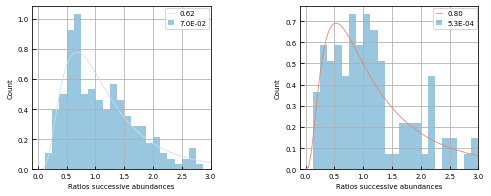

In [189]:
fig = plt.figure(figsize=(8,3))
gs = gridspec.GridSpec(1,2,wspace=0.5,hspace=0.5)

def fit_ratio(x):
    x = [x1/x2 for x1, x2 in zip(x[:-1], x[1:]) if x1 != 0 and x2 != 0]

    if len(x) > 5:
        a, b, c = stats.lognorm.fit(x, floc=0)  # Gives the paramters of the fit
        stat, pval = stats.kstest(x, 'lognorm', args=((a, b, c)))

        return a, b, c, stat, pval
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
                
cmap = plt.cm.get_cmap('coolwarm')

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
        
# plot different mean abundances, first sort the species
sorted_idces = ts.mean().sort_values().index.tolist()[::-1]
sorted_idces.remove('time')

mean = ts.mean()

for i, ax in zip([sorted_idces[3], sorted_idces[-3]], [ax1, ax2]):
    x = ts[i].values
    x_transf = [x1/x2 for x1, x2 in zip(x[:-1], x[1:]) if x1 != 0 and x2 != 0]
    
    a, b, c, stat, pval = fit_ratio(x)  # b = 0, c = 1

    x_fit = np.linspace(0,5,100)
    pdf_fitted = stats.lognorm.pdf(x_fit,a,b,c) #Gives the PDF

    ax.hist(x_transf, alpha=0.4, label='%.1E' % mean[i], density=True, bins = np.linspace(0,20,161))
    c = cmap(pval)
    ax.plot(x_fit, pdf_fitted, c=c, label='%.2f'%a)

    ax.set_xlim([-0.1,3])
    ax.legend() #loc=3)
    #ax.set_yscale('log')
    ax.set_ylabel('Count')
    ax.set_xlabel('Ratios successive abundances')
    ax.grid()

plt.show()

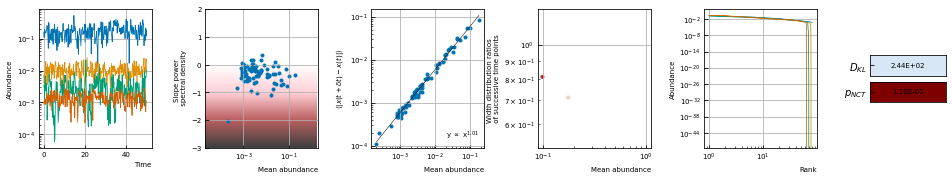

In [191]:
new = False

if new:
    N = 90
    params = {}

    steadystate = (experimental_abundance[:N]).reshape([N, 1])

    # interaction
    omega = np.zeros([N,N]); np.fill_diagonal(omega, -1) # np.random.normal(0,0.02,[N, N]);

    omega /= steadystate * 0.2

    params['interaction_matrix'] = omega

    # no immigration
    params['immigration_rate'] = np.zeros([N, 1])

    # different growth rates determined by the steady state
    params['growth_rate'] = - (omega).dot(steadystate)

    params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

    params['noise'] = 2.0

    params['noise_linear'] = 1.0 #1.5 #5e-1
    params['noise_sqrt'] = 3.0 #3.5 #5e-2

    ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, #_SQRT, 
                        dt = 0.01, tskip=49, T=100.0, seed=int(time.time())).timeseries
else:
    ts = pd.read_csv(folder + 'rescaled_timeseries.csv')

fig = plt.figure(figsize=(40/2.54,7/2.54))

PlotTimeseriesComparison([ts], composition=['ts', 'nc', 'dx', 'disdx', 'ra', 'nn'], vertical=False, fig=fig) #, ffig = 'figures/interaction_rescaled_model.png')
plt.show()